In [ ]:
#NOTE: the data is saved in random_everything.pkl (in running the below outbreak code to generate
    #data, you won't get same data values due to randomness of outbreak even with same seed 
    #location of farms and farm size)
#NOTE: using a different dataset, model coefficients are similar in signs and magnitude
#NOTE: fitting model using below code will yield very similar results but may not be exact due 
    #to stochasticity of MCMC

Main Idea
======
The goal of this notebook is to:

1) implement multiple outbreaks assuming the same initial conditions for each run

2) evaluate which farms are most at risk at a specific point in time during the outbreak

3) construct a Bayesian model which analyzes the relationship between a farm's infection status and other covariates

4) perform convergence checks on the model to assess fit

In this particular notebook the placement and size (number of cows and sheep) of farms will be assumed to be completely random. Other notebooks will repeat the above steps given other farm distribution and size characteristics.

The following code simulates an outbreak once using Keeling's "iterate" function which can be obtained from the "Modeling Infectious Diseases" website (Program 7.6). It returns an array with the following vectors: farmID, an indicator for disease status, distance of each farm to the index infected farm, number of cows at each farm, and number of sheep at each farm. The distance in this case is calculated using a standard euclidean distance. It is important to note that these distances are NOT to scale; the distances on the grid are represented in kilometers. 

In [1]:
import numpy as np
from random import randint
Size = 20
N = 1000 
np.random.seed(53080)
x = Size*np.random.rand(N)
np.random.seed(23003)
y = Size*np.random.rand(N)  
np.random.seed(10)
Cows = np.array([randint(200,500) for p in range(N)])
np.random.seed(11)
Sheep = np.array([randint(200,500) for p in range(N)])

In [2]:
def Outbreaks(Size,N,Y0,farms,end,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    #Cows = np.array([250]*N)  #Number of cows at each farm
    #Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    for i in range(Y0):
        Status[i] = 1

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(Status>5)[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        #for i in range(len(m)):
        #    Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),len(I) == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full

    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[640][0],coords[640][1]))
    dist = []
    dist.append(0)
    for i in range(1,N):
        b = np.array((coords[i][0],coords[i][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep]
    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep
    return(to_return)

The following code block implements the outbreak multiple times. It also positions each farm and assigns it a size (i.e - assigns number of cows and number of sheep). Both the locations and sizes are randomly generated using a uniform distribution. It is important to note that the number of cows and number of sheep vectors need to be different from each other (i.e. -each farm cannot have 250 cows and 250 sheep) asthis would results in linear dependency. For this reason the sizes are randomly generated.

In [3]:
import numpy as np
from random import randint
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)
Num_outbreaks = 500
for i in range(Num_outbreaks):
    new_Outbreak = np.r_[Outbreak,Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)]
    Outbreak = new_Outbreak 
run = np.ravel(list([i]*N for i in range(1,Num_outbreaks+2)))
data = np.c_[run,Outbreak]

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:92: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [27]:
#For ease turn data array into data frame
import pandas as pd
df = pd.DataFrame(data)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep']
long_random_everything = df

In [29]:
long_random_everything.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/long_random_everything.pkl') 

Now that the dataset has been created we will "flatten" it before implementing Bayesian Analysis. We currently have a dataset with 101,000 rows which leads to computational inefficiency. For this reason we will have a matrix of 1000 rows (one for each farm) and the "Status" variable will simply be the sum of the statuses over the 101 simulated outbreaks. Thus Status ~ Binomial(n=101, prob) rather than Status ~ Bernoulli(prob). The following code flattens the above dataset.

In [5]:
#Group by farmID then add across farmIDs 
farm_Status = df[['Status']].groupby(df.farmID)
sum_Status = farm_Status.agg(np.sum)
#Get rid of hierarchical header for data merge
sum_Status.columns = sum_Status.columns.get_level_values(0)
sum_Status2 = pd.DataFrame(sum_Status).reset_index()
#Add rest of data covariates
subset = df[:1000][['farmID','DistToIndex','NumCows','NumSheep']]
random_everything = pd.concat([sum_Status2, subset], axis=1, join_axes=[subset.index])
random_everything[640:]

,farmID,Status,farmID,DistToIndex,NumCows,NumSheep
640,641,501,641,0.000000,425,485
641,642,501,642,1.029099,454,249
642,643,501,643,0.411192,203,498
643,644,501,644,1.441540,273,496
644,645,501,645,1.101558,464,288
645,646,501,646,1.485211,381,331
646,647,501,647,2.812305,243,250
647,648,501,648,2.572874,491,269
648,649,501,649,3.859220,491,371
649,650,501,650,2.031243,293,464


In [26]:
#Save (or pickle) the dataset for future use
random_everything.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/random_everything.pkl') 

In [1]:
#Read the pickled dataset back in - prevents having to run all above code again
import pandas as pd
random_everything = pd.read_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/random_everything.pkl')

In [6]:
#This is the index exposed farm in the outbreak function
Status = np.array([0]*N)    #Initial Status of each farm
for i in range(1):
    Status[i] = 1
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
    #Returns a number from 1 to griddim^2
    return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

#Set up the grid
grid = WhichGrid(x,y,Size,Size,10.0,10.0)
tmp = sorted(grid) #Sort grid values
i = np.argsort(grid) #get indexed values after sort
Status = Status[i]
x = x[i]
y = y[i]
np.where(Status==1)

(array([640]),)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


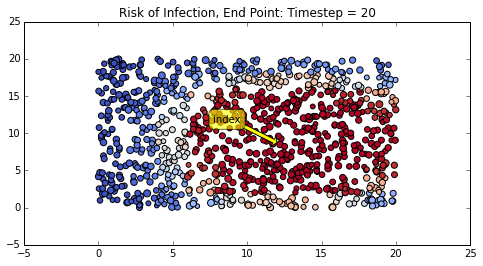

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,c=random_everything['Status'],cmap=plt.cm.coolwarm,s=(Cows+Sheep)/20)
plt.title('Risk of Infection, End Point: Timestep = 20')
plt.annotate('index', xy = (x[640], y[640]), xytext = (-40, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha = 0.6),
        arrowprops=dict(facecolor='yellow', shrink=0.08))


plt.show()

Now that the dataset has been flattened we can construct the Bayesian Model.

In [8]:
dist_diff = random_everything['DistToIndex'] - random_everything['DistToIndex'].mean()
cows_diff = random_everything['NumCows'] - random_everything['NumCows'].mean()
sheep_diff = random_everything['NumSheep'] -random_everything['NumSheep'].mean()
status = random_everything['Status']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0.5) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = -0.05)
    
    b = Normal('b', mu=0., tau=0.001, value = [0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, b=b: invlogit(intercept + first_coef*dist_diff + b[0]*cows_diff 
                                               + b[1]*sheep_diff))
    
    y = Binomial('y', n=501, p=prob, value=status, observed=True)
    
    return locals()

In [9]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 24.6 sec

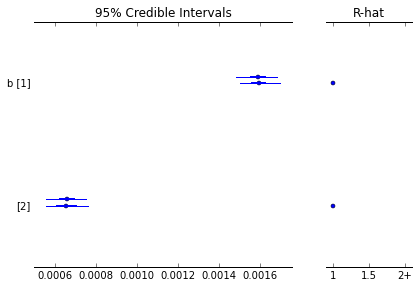

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.b)

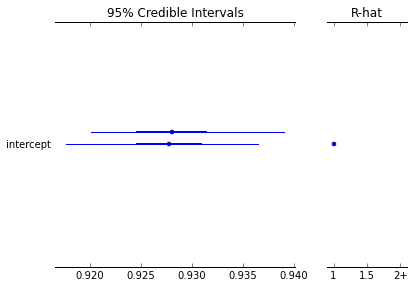

In [11]:
Matplot.summary_plot(M_pooled.intercept)

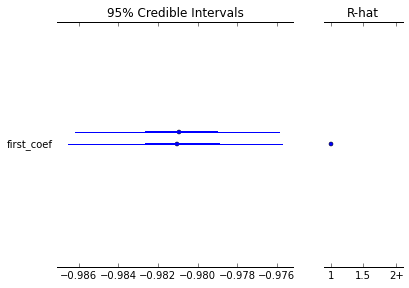

In [12]:
Matplot.summary_plot(M_pooled.first_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


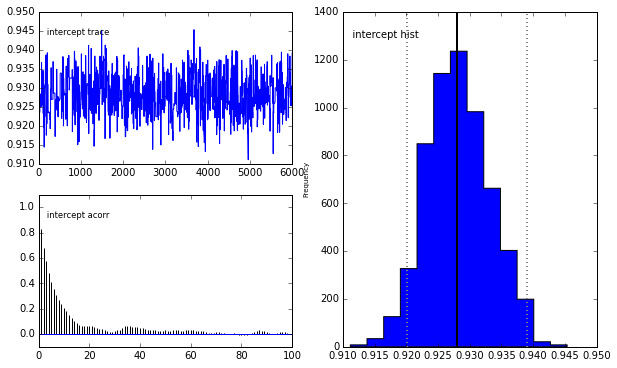

In [13]:
Matplot.plot(M_pooled.intercept)

Plotting b_0
Plotting b_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


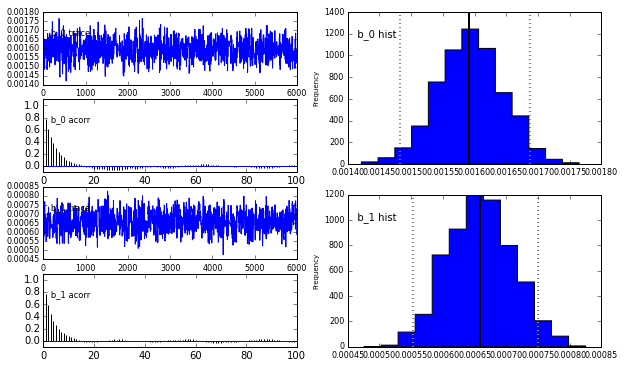

In [14]:
Matplot.plot(M_pooled.b, common_scale=False)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


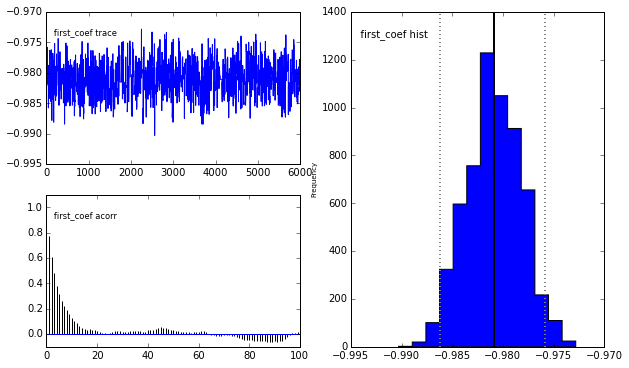

In [15]:
Matplot.plot(M_pooled.first_coef, common_scale=False)

In [16]:
from pymc import gelman_rubin
gelman_rubin(M_pooled)

{'b': [1.001785496058188, 1.0010865793300974],
 'first_coef': 0.99984392581125692,
 'intercept': 1.007657207616971,
 'prob': [1.0002654775431277,
  1.0008162157223577,
  1.0004769262566455,
  1.0012011003845371,
  1.0018293612045215,
  1.0004251176096559,
  1.0028117033872428,
  1.0005073209023498,
  0.99984563671616944,
  1.0017303710367675,
  1.0012753829136791,
  1.0004160009712617,
  0.99988641713664794,
  1.0017790554322565,
  1.0005530549285517,
  1.0026993688336097,
  1.0000397659683764,
  1.0030725995447145,
  1.0020621865332318,
  1.0042850677222992,
  1.000042340855436,
  1.003590180736228,
  1.0026672092159306,
  1.0014489248146052,
  1.0055457755843036,
  1.0028387209838643,
  1.0023751201455502,
  1.0006696050213286,
  1.0059359700404631,
  0.99995542445715091,
  1.0019398009470095,
  1.003498185237472,
  1.0041909175709258,
  1.0000245925361237,
  1.0012321824988262,
  1.0065662947028209,
  1.0046787468386209,
  0.99983864657387456,
  1.0034407470275892,
  0.9998602420617

In [17]:
M_pooled.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.002            0.0              0.0              [ 0.002  0.002]
	0.001            0.0              0.0              [ 0.001  0.001]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.001            0.002           0.002          0.002         0.002
	0.001            0.001           0.001          0.001         0.001
	


In [18]:
M_pooled.intercept.summary()


intercept:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.928            0.005            0.0              [ 0.919  0.938]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.919            0.925           0.928          0.931         0.938
	


In [19]:
M_pooled.first_coef.summary()


first_coef:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.981           0.003            0.0              [-0.987 -0.976]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.986           -0.983          -0.981         -0.979        -0.975
	


In [20]:
import numpy as np
#Intercept: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('intercept')[:].mean()),np.exp(np.percentile(M_pooled.trace('intercept')[:],2.5)),np.exp(np.percentile(M_pooled.trace('intercept')[:],97.5)))

(2.5299785790416753, 2.5063137592608906, 2.5559194983662681)

In [22]:
#distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.37497576816128902, 0.37299988641211324, 0.37692822210463994)

In [23]:
# #cows: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,0],97.5)))

(1.001593918730775, 1.0014888433517519, 1.0016966255056678)

In [24]:
# #sheep: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,1],97.5)))

(1.0006591262089515, 1.0005587562712277, 1.0007602621957885)